# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
# !pip install ipywidgets

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
# NOTE: may need to restart kernel after install
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
# from ipywidgets import IntProgress

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Create training set and define training dataloader
training_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

batch_size = 64
# Create test set and define test dataloader
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

Here use ToTensor() and Normalize() in the transforms. `ToTensor()` is to converts the image dataset into tensor for the following step to build neural network.`Normalize()` is to normalize the data which is usually beneficial for training the model.The values 0.1307 and 0.3081 used for the `Normalize()` transformation above are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


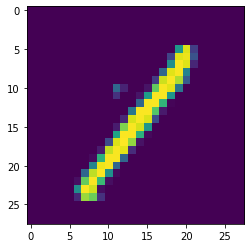

2


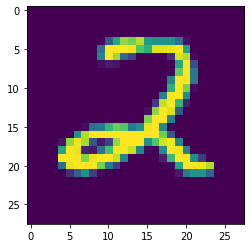

5


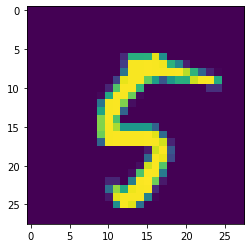

0


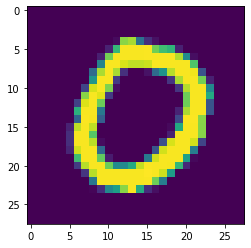

0


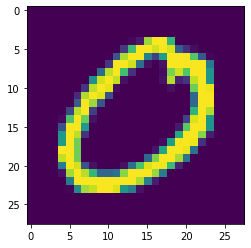

In [6]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

The network will take input Tensor with dimeansion of 784(28*28), and generate the output Tensor with length of 10(number of class in dataset) that has score for each class. The network has 2 hiddenlayers with Relu as activation function


In [7]:
# Define the Network Architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # activation function Relu
        self.activation = F.relu
        # linear layer (784 -> hidden layer1 120)
        self.layer1 = nn.Linear(28*28, 120)
        # linear layer (hidden layer1 120 -> hidden layer2 84)
        self.layer2 = nn.Linear(120, 84)
        # linear layer (hidden layer2 84 -> 10)
        self.layer3 = nn.Linear(84, 10)

    
    def forward(self, x):
        # flatten image input
        x = torch.flatten(x, 1)
        # add hidden layer, with relu activation function
        x = self.activation(self.layer1(x))
        # add hidden layer, with relu activation function
        x = self.activation(self.layer2(x))
        # add output layer
        x = self.layer3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)
print(net)

Net(
  (layer1): Linear(in_features=784, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=84, bias=True)
  (layer3): Linear(in_features=84, out_features=10, bias=True)
)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
# specify optimizer (Adaptive Moment Estimation) and learning rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=0.01)

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()


Here use Adam (Adaptive Moment Estimation) as optimizer. The learning rate does not vanish and convers quickly. The loss function use cross entropy. Cross-Entropy is one of the best ways to describe the difference between the prediction and the true labels.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

Use the train DataLoader to train the neural network:

- Zero out the gradients of the optimizer
- Get the output of model and computer the loss
- Compute the loss gradient using the backward method an dhave the optimizer take a step
- Compute the accuracy

In [9]:
num_epochs = 10

# Establish a list for loss record
train_loss_hist = list()
val_loss_hist = list()

for epoch in range(num_epochs):
    
    # prepare the model for training
    net.train()
    train_loss = 0.0
    train_correct = 0
    
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, label]
        inputs, labels = data
        
        # pass to GPU if available
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        # zero out the gradients of the optimizer
        optimizer.zero_grad()
        
        # forward pass: get the output of model and computer the loss
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # backward pass: compute the loss gradient using the backward method
        loss.backward()
        # have the optimizer take a step
        optimizer.step()
        
        # compute the accuracy and print the accuracy and loss
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {100*train_correct/len(train_loader.dataset): .2f}% training loss: {train_loss/len(train_loader.dataset): .5f}')
    train_loss_hist.append(train_loss/len(train_loader.dataset))
    
    # validation step
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {100*val_correct/len(test_loader.dataset):.2f}% validation loss: {100*val_loss/len(test_loader.dataset):.5f}')
    val_loss_hist.append(val_loss/len(test_loader.dataset))

Epoch 1 training accuracy:  91.17% training loss:  0.00464
Epoch 1 validation accuracy: 94.31% validation loss: 0.33014
Epoch 2 training accuracy:  94.65% training loss:  0.00307
Epoch 2 validation accuracy: 95.21% validation loss: 0.29497
Epoch 3 training accuracy:  95.19% training loss:  0.00279
Epoch 3 validation accuracy: 95.74% validation loss: 0.25402
Epoch 4 training accuracy:  95.29% training loss:  0.00275
Epoch 4 validation accuracy: 94.70% validation loss: 0.34500
Epoch 5 training accuracy:  95.93% training loss:  0.00240
Epoch 5 validation accuracy: 95.75% validation loss: 0.24850
Epoch 6 training accuracy:  96.14% training loss:  0.00233
Epoch 6 validation accuracy: 94.94% validation loss: 0.33317
Epoch 7 training accuracy:  96.38% training loss:  0.00220
Epoch 7 validation accuracy: 95.81% validation loss: 0.28601
Epoch 8 training accuracy:  96.40% training loss:  0.00223
Epoch 8 validation accuracy: 95.55% validation loss: 0.33745
Epoch 9 training accuracy:  96.61% train

Plot the training loss (and validation loss/accuracy, if recorded).

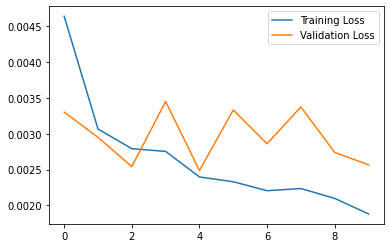

In [10]:
# Plot the trainning and validation 
plt.plot(train_loss_hist, label="Training Loss")
plt.plot(val_loss_hist, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
# Test model
test_loss = 0.0
test_correct = list(0 for i in range(10))
test_total = list(0 for i in range(10))

# prepare the model for testing
net.eval()

for inputs, labels in test_loader:
    # pass to GPU if available
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
    
    # compute the prediction 
    outputs = net(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)
    correct = preds == labels
    for i in range(len(labels.data)):
        label = labels.data[i].item()
        test_correct[label] += correct[i]
        test_total[label] += 1
        
    test_loss += loss.item()

test_loss = test_loss/len(test_loader)
print(f'Test Loss: {test_loss:.5f}')

for i in range(10):
    if test_total[i] > 0:
        print(f'Test Accuracy of {str(i)}: {100*test_correct[i] / test_total[i]: .2f}%')
    else:
        print(f'Test Accuracy of {str(i)}:  N/A (no training examples')

print(f'Test Accuracy (Overall): {100*np.sum(test_correct) / np.sum(test_total): .2f}%')


Test Loss: 0.16453
Test Accuracy of 0:  98.57%
Test Accuracy of 1:  97.89%
Test Accuracy of 2:  94.48%
Test Accuracy of 3:  97.33%
Test Accuracy of 4:  96.02%
Test Accuracy of 5:  95.17%
Test Accuracy of 6:  97.07%
Test Accuracy of 7:  96.97%
Test Accuracy of 8:  95.99%
Test Accuracy of 9:  94.14%
Test Accuracy (Overall):  96.38%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [13]:
# Define the Network Architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # activation function Relu
        self.activation = F.relu
        # linear layer (784 -> hidden layer1 120)
        self.layer1 = nn.Linear(28*28, 120)
        # linear layer (hidden layer1 120 -> hidden layer2 84)
        self.layer2 = nn.Linear(120, 84)
        # linear layer (hidden layer2 84 -> 10)
        self.layer3 = nn.Linear(84, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # flatten image input
        x = torch.flatten(x, 1)
        # add hidden layer, with relu activation function
        x = self.activation(self.layer1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = self.activation(self.layer2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.layer3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)
print(net)

Net(
  (layer1): Linear(in_features=784, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=84, bias=True)
  (layer3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [14]:
# specify optimizer (Adaptive Moment Estimation) and learning rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=0.01)

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()


In [16]:
num_epochs = 10

# Establish a list for loss record
train_loss_hist = list()
val_loss_hist = list()

for epoch in range(num_epochs):
    
    # prepare the model for training
    net.train()
    train_loss = 0.0
    train_correct = 0
    
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, label]
        inputs, labels = data
        
        # pass to GPU if available
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        # zero out the gradients of the optimizer
        optimizer.zero_grad()
        
        # forward pass: get the output of model and computer the loss
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # backward pass: compute the loss gradient using the backward method
        loss.backward()
        # have the optimizer take a step
        optimizer.step()
        
        # compute the accuracy and print the accuracy and loss
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {100*train_correct/len(train_loader.dataset): .2f}% training loss: {train_loss/len(train_loader.dataset): .5f}')
    train_loss_hist.append(train_loss/len(train_loader.dataset))
    
    # validation step
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {100*val_correct/len(test_loader.dataset):.2f}% validation loss: {100*val_loss/len(test_loader.dataset):.5f}')
    val_loss_hist.append(val_loss/len(test_loader.dataset))

Epoch 1 training accuracy:  90.07% training loss:  0.00579
Epoch 1 validation accuracy: 93.54% validation loss: 0.37555
Epoch 2 training accuracy:  90.86% training loss:  0.00539
Epoch 2 validation accuracy: 93.60% validation loss: 0.40174
Epoch 3 training accuracy:  91.33% training loss:  0.00526
Epoch 3 validation accuracy: 93.75% validation loss: 0.37793
Epoch 4 training accuracy:  91.59% training loss:  0.00516
Epoch 4 validation accuracy: 93.85% validation loss: 0.35676
Epoch 5 training accuracy:  91.50% training loss:  0.00515
Epoch 5 validation accuracy: 94.28% validation loss: 0.37610
Epoch 6 training accuracy:  91.56% training loss:  0.00515
Epoch 6 validation accuracy: 94.13% validation loss: 0.36980
Epoch 7 training accuracy:  91.81% training loss:  0.00501
Epoch 7 validation accuracy: 93.79% validation loss: 0.37680
Epoch 8 training accuracy:  91.87% training loss:  0.00489
Epoch 8 validation accuracy: 93.94% validation loss: 0.36697
Epoch 9 training accuracy:  91.90% train

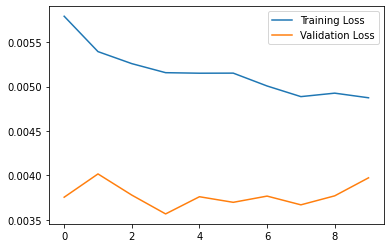

In [18]:
# Plot the trainning and validation 
plt.plot(train_loss_hist, label="Training Loss")
plt.plot(val_loss_hist, label="Validation Loss")
plt.legend()
plt.show()

In [17]:
# Test model
test_loss = 0.0
test_correct = list(0 for i in range(10))
test_total = list(0 for i in range(10))

# prepare the model for testing
net.eval()

for inputs, labels in test_loader:
    # pass to GPU if available
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
    
    # compute the prediction 
    outputs = net(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)
    correct = preds == labels
    for i in range(len(labels.data)):
        label = labels.data[i].item()
        test_correct[label] += correct[i]
        test_total[label] += 1
        
    test_loss += loss.item()

test_loss = test_loss/len(test_loader)
print(f'Test Loss: {test_loss:.5f}')

for i in range(10):
    if test_total[i] > 0:
        print(f'Test Accuracy of {str(i)}: {100*test_correct[i] / test_total[i]: .2f}%')
    else:
        print(f'Test Accuracy of {str(i)}:  N/A (no training examples')

print(f'Test Accuracy (Overall): {100*np.sum(test_correct) / np.sum(test_total): .2f}%')


Test Loss: 0.25471
Test Accuracy of 0:  97.75%
Test Accuracy of 1:  97.26%
Test Accuracy of 2:  94.28%
Test Accuracy of 3:  93.26%
Test Accuracy of 4:  93.15%
Test Accuracy of 5:  93.60%
Test Accuracy of 6:  96.35%
Test Accuracy of 7:  92.32%
Test Accuracy of 8:  95.06%
Test Accuracy of 9:  92.35%
Test Accuracy (Overall):  94.56%


## Saving your model
Using `torch.save`, save your model for future loading.

In [20]:
# Save the model
torch.save(net, 'mnist_classifier.pt')